In [2]:
import pandas as pd
import healpy as hp
import numpy as np
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = './COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt'

if not os.path.isfile(path):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/cosmoparams/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt

In [4]:
cl = pd.read_csv(
    "COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt",               
    delim_whitespace=True, 
    index_col=0
)

cl.head()

TT       TE        EE        BB            PP
L                                                     
2  1016.730  2.61753  0.030883  0.000002  5.013520e-08
3   963.727  2.93806  0.039690  0.000004  6.099430e-08
4   912.608  2.75866  0.034496  0.000006  7.025920e-08
5   874.477  2.35185  0.023094  0.000009  7.829210e-08
6   848.509  1.89605  0.012951  0.000013  8.530200e-08

In [5]:
cl.plot(grid=True);
plt.title("Leistungsspektrum")
plt.xlabel(r"$\ell$ [arcmin]")
plt.ylabel("$\dfrac{\ell(\ell+1)}{2\pi} C_\ell~[\mu K^2]$", labelpad=-4)
plt.xlim([50, 2500]);

plt.savefig("Leistungsspektrum.png")
plt.show()

In [6]:
cl.plot(logx=True, logy=True, grid=True);
plt.title("Logarithmische Sklalierung vom Leistungsspektrum")
plt.xlabel("$\log (\ell )$ [arcmin]")
plt.ylabel("$\dfrac{\ell(\ell+1)}{2\pi} C_\ell~[\mu K^2]$", labelpad=-4)
plt.xlim([50, 2500]);
plt.savefig("Logarithmische Sklalierung vom Leistungsspektrum.png")
plt.show()

In [8]:
cl.TT.plot(logx=False, logy=False, grid=True)
plt.title("Leistungsspektrum TT")
plt.ylabel("$\dfrac{\ell(\ell+1)}{2\pi} C_\ell~[\mu K^2]$", labelpad=-6)
plt.xlabel(r"$\ell$ [arcmin]")
plt.xlim([50, 2500]);
plt.savefig("Leistungsspektrum_TT.png")

plt.show()

In [9]:
#Rausteilen vom Vorfaktor auf y-Achse und umrechnen von (mikro K)^2 in K^2
cl_corrected = cl.divide(cl.index * (cl.index+1) / (np.pi*2), axis="index")
cl_corrected /= 1e12

cl_corrected.head()

TT            TE            EE            BB            PP
L                                                                      
2  1.064717e-09  2.741071e-12  3.234029e-14  1.904297e-18  5.250146e-20
3  5.046063e-10  1.538365e-12  2.078179e-14  1.904554e-18  3.193654e-20
4  2.867043e-10  8.666586e-13  1.083730e-14  1.904889e-18  2.207258e-20
5  1.831500e-10  4.925703e-13  4.836817e-15  1.905307e-18  1.639746e-20
6  1.269366e-10  2.836484e-13  1.937495e-15  1.905810e-18  1.276115e-20

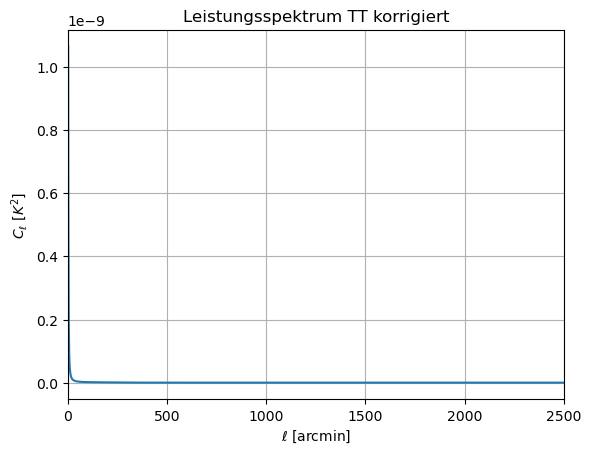

In [10]:
cl_corrected.TT.plot(logx=False, logy=False, grid=True)
plt.ylabel("$C_\ell~[K^2]$")
plt.xlabel(r"$\ell$ [arcmin]")
plt.title("Leistungsspektrum TT korrigiert")

plt.xlim([0, 2500]);

plt.savefig("Leistungsspektrum_TT_corr.png")

plt.show()

In [11]:
# auffüllen der Tabele mit l = 0,1 wobei alle Werte auf 0 gesetzt werden
lmax = cl.index[-1]
cl_corrected = cl_corrected.reindex(np.arange(0, lmax+1))
cl_corrected = cl_corrected.fillna(0)
cl_corrected.head()

TT            TE            EE            BB            PP
L                                                                      
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
2  1.064717e-09  2.741071e-12  3.234029e-14  1.904297e-18  5.250146e-20
3  5.046063e-10  1.538365e-12  2.078179e-14  1.904554e-18  3.193654e-20
4  2.867043e-10  8.666586e-13  1.083730e-14  1.904889e-18  2.207258e-20

In [10]:
#seed = 583
seed = 43
np.random.seed(seed)

In [11]:
sim_num = 100

In [12]:
nside = 1024

In [13]:
overwrite = False

In [15]:
#Funktion wandelt Pixelnummer in Winkel um
def IndexToDecRa(index):
    theta,phi=hp.pixelfunc.pix2ang(nside,index)
    return -np.degrees(theta-np.pi/2.), np.degrees(np.pi*2.-phi)

In [16]:
path_coord = './cmb_coord.csv'

if not os.path.isfile(path_coord):
    DEC = []
    RA = []
    for index in range(50331648):
        dec, ra = IndexToDecRa(index)
        DEC.append(dec)
        RA.append(ra)
        if (index%1000000 == 0):
            print(str(index/50331648*100)+"%")
    
    coord = np.c_[DEC, RA]
    
    np.savetxt("cmb_coord.csv", coord, delimiter=",")

In [17]:
for i in range(sim_num):
    
    if os.path.isfile(f"./cmb_sim_{i}.fits") and overwrite == False :
        continue
    
    cmb_sim = hp.synfast(
        (cl_corrected.TT, cl_corrected.EE, cl_corrected.BB, cl_corrected.TE), 
        nside = nside, 
        lmax=lmax, 
        new=True
    )
    
    hp.write_map(
        f"cmb_sim_{i}.fits", 
        cmb_sim, 
        dtype=np.float32, 
        overwrite = overwrite,
        #column_names = ['TEMPERATURE', 'Q_POLARISATION', 'U_POLARISATION', 'DEC', 'RA']
    )

In [20]:
t = hp.read_map("cmb_sim_52.fits")
hp.mollview(
    t*(10**6),
    unit = "Temperaturfluktuation $[\mu K]$",
    title = "zufällig generierte CMB Karte",
    max = 300,
    min = -300
)

plt.savefig("random_cmb.png")